In [1]:
import torch
import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

import matplotlib.pyplot as plt
import seaborn as sn

# Support libraries
import numpy as np
import pandas as pd
import itertools
import os
import random
from PIL import Image
from sklearn.metrics import jaccard_score

### Dataset Class

In [2]:
class ParticleSeg(Dataset):
    
    def __init__(self, root_dir:str, img_transforms:object=None, mask_transforms:object=None):
        
        super().__init__()
        
        self.root_dir = root_dir
        self.transforms_mask = mask_transforms
        self.transforms_img = img_transforms
        
        self.mask_dir = os.path.join(root_dir, "segmaps")
        self.img_dir = os.path.join(root_dir, "images")
        
        self.file_names = os.listdir(self.mask_dir)
        self.mask_paths = [os.path.join(self.mask_dir, mask_name) for mask_name in self.file_names]
        self.img_paths = [os.path.join(self.img_dir, img_name) for img_name in self.file_names]
   

    def __len__(self):
        
        return len(self.file_names)

    def __getitem__(self, ix:int):

        seed = np.random.randint(2022)
        random.seed(seed)
        torch.manual_seed(seed)

        mask_path, img_path = self.mask_paths[ix], self.img_paths[ix]

        mask, img = Image.open(mask_path), Image.open(img_path).convert('RGB')

        if self.transforms_img is not None:

            img = self.transforms_img(img)

        random.seed(seed)
        torch.manual_seed(seed)

        if self.transforms_mask is not None:

            mask = self.transforms_mask(mask)

        mask, img = mask.float(), img.float()
        
        mask[mask > 0 ] = 1
#         img = img / 255

        return img, mask

### Transformations

In [3]:
img_transforms = T.Compose([
    T.ToTensor(),
    T.GaussianBlur(5),
    T.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.Resize((244,244)),
])


mask_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((244,244))
])

### Creating General Dataset

In [4]:
dataset = ParticleSeg(
    root_dir='/kaggle/input/electron-microscopy-particle-segmentation', 
    img_transforms=img_transforms,
    mask_transforms=mask_transforms
)

### Visualising Dataset

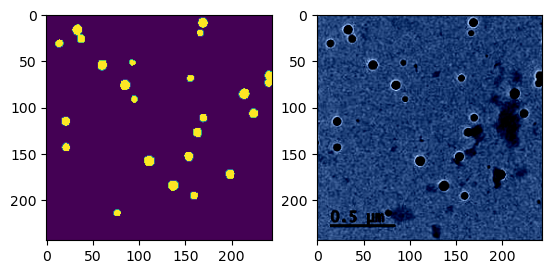

In [5]:
mask, img = dataset[8]

fig, ax = plt.subplots(nrows=1, ncols=2)

pos1 = ax[0].imshow(img.permute((1, 2, 0)))
pos2 = ax[1].imshow(mask.permute((1, 2, 0)))

### Splitting Dataset for Training & Validation

In [6]:
dataset_train, dataset_val = random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])

print(len(dataset_train), len(dataset_val))

372 93


### Dataloaders

In [7]:
dataloader_train = DataLoader(dataset_train, batch_size = 16)
dataloader_val = DataLoader(dataset_val, batch_size = 16)

### Defining Model

In [8]:
def createDeepLabv3(outputchannels=1):
    model = models.segmentation.deeplabv3_resnet50(pretrained=True,
                                                    progress=True)
    model.classifier = DeepLabHead(2048, outputchannels)
    return model

### Training

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = createDeepLabv3(1).to(device)
criterion =  nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
epochs = 10

def train(model, dataloader):
    model.train()
    train_loss = 0
    for data in dataloader:
        optimizer.zero_grad()
        
        images, masks = data[0].to(device), data[1].to(device)
        out = model(images)['out']
        
        loss = criterion(out, masks)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss/ len(dataloader)

def test(model, dataloader):
    model.eval()
    test_loss = 0
    train_iou = 0
    for data in dataloader:        
        images, masks = data[0].to(device), data[1].to(device)
        out = model(images)['out']
        
        loss = criterion(out, masks)
        test_loss += loss.item()
        
        train_iou += jaccard_score(masks.detach().cpu().flatten().numpy(), 
                      out.detach().cpu().flatten().numpy() > 0.99)
        
    return test_loss/ len(dataloader), train_iou / len(dataloader)

train_loss_lst = []
test_loss_lst = []
for epoch in range(epochs):
    train_loss = train(model, dataloader_train)
    train_loss_lst.append(train_loss)

    val_loss, val_iou = test(model, dataloader_val)
    test_loss_lst.append(val_loss)
    
    print('Epoch [{}/{}], Train loss: {:.4f}, Val loss {:.4f}, Val IoU {:.4f}'.format(epoch+1, epochs, train_loss, val_loss, val_iou))    

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


  0%|          | 0.00/161M [00:00<?, ?B/s]

Epoch [1/10], Train loss: 0.2993, Val loss 0.2522, Val IoU 0.5635
Epoch [2/10], Train loss: 0.1777, Val loss 0.1692, Val IoU 0.8359
Epoch [3/10], Train loss: 0.1252, Val loss 0.1356, Val IoU 0.8112
Epoch [4/10], Train loss: 0.1035, Val loss 0.1336, Val IoU 0.8623
Epoch [5/10], Train loss: 0.0850, Val loss 0.1079, Val IoU 0.8646
Epoch [6/10], Train loss: 0.0718, Val loss 0.1109, Val IoU 0.8894
Epoch [7/10], Train loss: 0.0628, Val loss 0.1010, Val IoU 0.8878
Epoch [8/10], Train loss: 0.0587, Val loss 0.1072, Val IoU 0.8942
Epoch [9/10], Train loss: 0.0577, Val loss 0.1102, Val IoU 0.8720
Epoch [10/10], Train loss: 0.0601, Val loss 0.1340, Val IoU 0.7840


### Visualise Loss

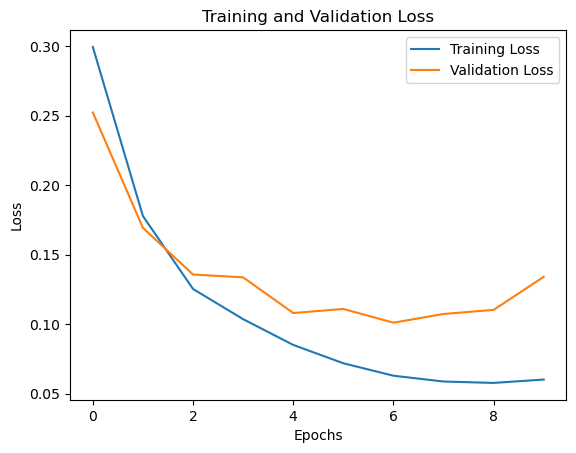

In [10]:
plt.plot(train_loss_lst, label='Training Loss')
plt.plot(test_loss_lst, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc='best')
plt.show()

### Visualise Segmentation

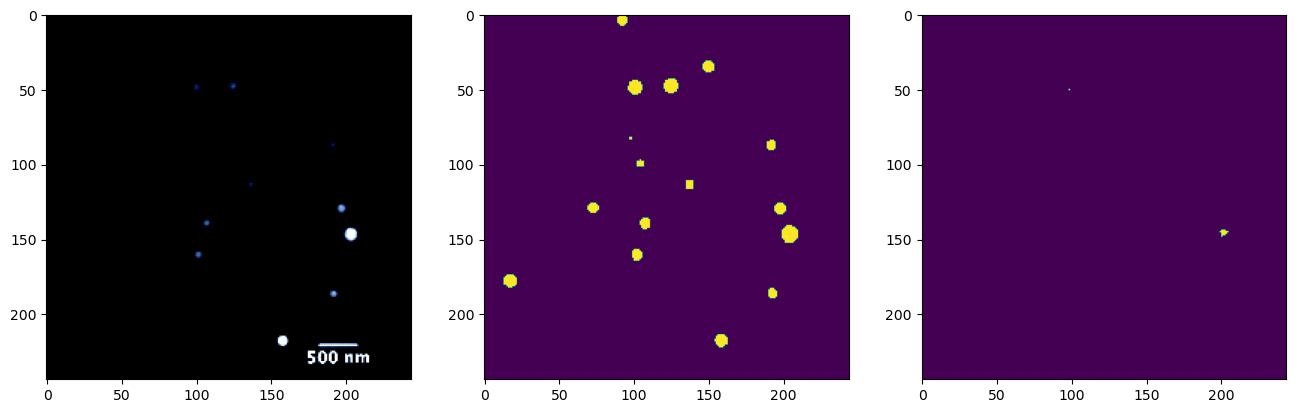

In [11]:
dataiter = iter(dataloader_train)
images, masks = next(dataiter)

images = images.to(device)
output = model(images)['out']

image_indx = 5
thresh_img = output[image_indx].cpu().detach() > 0.999

fig, axs = plt.subplots(1, 3, figsize=(16,9))
axs[0].imshow(images[image_indx].cpu().permute((1, 2, 0)))
axs[1].imshow(masks[image_indx].cpu().permute((1, 2, 0)))
axs[2].imshow(thresh_img.permute((1, 2, 0)))